In [1]:
import numpy as np
from PIL import Image

In [2]:
import random
import cv2
import numpy as np

import donkeybarn as barn
import os

In [3]:
class AugmentPipeline:
    def __init__(self, data):
        self.data = data.copy()
        self.pipeline = []
        
    def add(self, processor, input_ix=[0, ], chance=.2):
        self.pipeline.append(
            {'processor': processor,
             'input_ix': input_ix,
             'chance': chance})
        
    def run(self, gen_count=None):
        
        if gen_count==None:
            gen_count = len(self.data)
            
        results = []
        
        #get row of data
        for i in range(gen_count): 
            row_num = np.random.randint(0,len(self.data))
        
            row = self.data[row_num].copy()
            
            #run row of data through pipeline
            for p in self.pipeline:
                
                #only run pipeline step if chance test succedes
                if p['chance'] > random.random():
            
                    #get inputs
                    inputs = []
                    for input_ix in p['input_ix']:
                        inputs.append(row[input_ix])
                    
                    #run processor
                    result = p['processor'].run(inputs)
                    
                    for i, output_ix in enumerate(p['input_ix']):
                        row[output_ix] = result[i]
            
            results.append(row)
        
        results = np.stack(results)        
        return results

In [4]:
bp = barn.cv.augment.BaseProcessor()

class ToOneProcessor(barn.cv.augment.BaseProcessor):
    def run_arr(self, x):
        return 1
one = ToOneProcessor()


data = np.linspace(1,100,num=100).reshape((10,10))

apipe = AugmentPipeline(data)
apipe.add(bp,input_ix=[8], chance=1 )
apipe.add(one, input_ix=[4], chance=1)
apipe.run()



array([[  1.,   2.,   3.,   4.,   1.,   6.,   7.,   8.,   9.,  10.],
       [ 41.,  42.,  43.,  44.,   1.,  46.,  47.,  48.,  49.,  50.],
       [ 91.,  92.,  93.,  94.,   1.,  96.,  97.,  98.,  99., 100.],
       [ 61.,  62.,  63.,  64.,   1.,  66.,  67.,  68.,  69.,  70.],
       [ 11.,  12.,  13.,  14.,   1.,  16.,  17.,  18.,  19.,  20.],
       [ 81.,  82.,  83.,  84.,   1.,  86.,  87.,  88.,  89.,  90.],
       [ 51.,  52.,  53.,  54.,   1.,  56.,  57.,  58.,  59.,  60.],
       [ 31.,  32.,  33.,  34.,   1.,  36.,  37.,  38.,  39.,  40.],
       [ 61.,  62.,  63.,  64.,   1.,  66.,  67.,  68.,  69.,  70.],
       [ 51.,  52.,  53.,  54.,   1.,  56.,  57.,  58.,  59.,  60.]])

In [5]:
#download and load dataset


#location where to save datasets
data_dir = os.path.expanduser('~/donkey_data')

print(barn.__file__)

#track_data = barn.datasets.DriveaiLabeled.load(data_dir = data_dir)
track_data = barn.datasets.MakerFaireLabeled.load(data_dir = data_dir)
#load camera model to undistort and do birdseye perspective
fe = barn.cv.camera.FishEyeCamera(**barn.configs.donkey2_camera_params)

#load image labels
label_json_path = os.path.join(track_data.base_dir, 'labels.json')
data= barn.datasets.LabelBoxData(label_json_path)
data.gen_external_key_index()

/home/wroscoe/donkey/donkeybarn/donkeybarn/__init__.py
File already exists.


In [6]:
X = []
for ix in range(len(track_data.img_paths)):
    img_name = os.path.basename(track_data.img_paths[ix])
    img = np.array(Image.open(track_data.img_paths[ix]))

    mask = np.array(data.get_mask_from_key(img_name, 'Center Line'))
    mask_undistorted = fe.undistort(mask)
    mask_birdseye = fe.birdseye(mask_undistorted)

    #output the coefficients of the line [c2, c1, c0] such that 
    # c2*x**2 + c1*x + c0 = y
    coef = barn.cv.lanes.find_line_coef_from_mask(mask_birdseye)
    X.append([img, coef])

In [7]:
X_arr = np.array(X)

In [8]:
X_arr[1][1].shape

(3,)

In [9]:
flp = barn.cv.augment.RandomFlip(func_on_flip=barn.cv.lanes.flip_line_coef)
rec = barn.cv.augment.RandomRectangles()
blur = barn.cv.augment.RandomBlur()
bright = barn.cv.augment.RandomBrightness()

# format (chance, instance, mapping of array columns)
     
apipe = AugmentPipeline(X)
apipe.add(flp, input_ix=[0,1])
apipe.add(rec, input_ix=[0] )
apipe.add(blur, input_ix=[0])
X_aug = apipe.run(gen_count=5)



In [14]:
Y = X_aug[:, 1]
X = X_aug[:, 0]

In [22]:
ix = 6
img = X[ix]
img_undist = fe.undistort(img)
img_birdseye = fe.birdseye(img_undist)
coef = Y[ix]
img_with_lines = barn.cv.draw.line_from_coef(img_birdseye, coef )

IndexError: index 6 is out of bounds for axis 0 with size 5

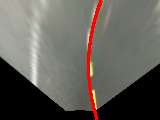

In [23]:
Image.fromarray(img_with_lines)

In [13]:
Y

array([array([-3.03030303e-04, -4.13636364e-01,  1.04863636e+02]),
       array([-1.40151515e-03,  2.97727273e-01,  9.57736742e+01]),
       array([-4.16666667e-04,  3.72619048e-01,  3.99866071e+01]),
       array([-2.43589744e-03,  4.36130536e-01,  7.65445804e+01]),
       array([ 2.97202797e-03, -3.87412587e-01,  1.01170455e+02])],
      dtype=object)

In [10]:
x, y = (1,2,)

In [20]:
np.take(np.zeros(3), [0,1])

array([0., 0.])

In [ ]:
apipe = AugmentPipeline()

In [11]:
img = Image.open('/home/wroscoe/donkey_data/track_2/1001_cam-image_array_.jpg')
arr = np.array(img)
print(arr.shape)
x, y = flp.run(arr, 1)
x, y = rec.run(x, y)
x, y = blur.run(x, y)
x, y = bright.run(x, y)
img = Image.fromarray(x)

(120, 160, 3)


TypeError: run() takes 2 positional arguments but 3 were given

/home/wroscoe/donkey/donkeybarn/donkeybarn/__init__.py
File already exists.


In [14]:
ix  = 200
img_name = os.path.basename(track_data.img_paths[ix])
img = np.array(Image.open(track_data.img_paths[ix]))

img_undistort = fe.undistort(img)
img_bird = fe.birdseye(img_undistort)

mask = np.array(data.get_mask_from_key(img_name, 'Center Line'))
mask_undistorted = fe.undistort(mask)
mask_birdseye = fe.birdseye(mask_undistorted)

#output the coefficients of the line [c2, c1, c0] such that 
# c2*x**2 + c1*x + c0 = y
coef = barn.cv.lanes.find_line_coef_from_mask(mask_birdseye)

In [94]:
coef



array([ 3.49650350e-04, -1.16363636e-01,  7.72821678e+01])

In [96]:
coef_rev = flip_line_coef(coef)

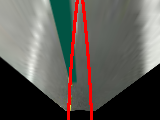

In [97]:
arr = barn.cv.draw.line_from_coef(img_bird, coef_rev)
arr = barn.cv.draw.line_from_coef(arr, coef)
Image.fromarray(arr)

In [107]:
arr2 = cv2.drawMarker(arr, (50,50), color=(255,255, 255))

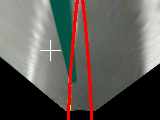

In [108]:
Image.fromarray(arr2)

In [ ]:
np.polyint

In [119]:










    
def augment_images(arr):
cv2.rectangle(arr, tl, br, color, -1)    arr = add_rectangles(arr, n=4)
    arr = random_blur(arr, probability=.2, min_kernal_size=2, max_kernal_size=4)
    arr = random_brightness(arr)
    return arr
